In [2]:
from tensorflow.keras.layers import Input, Lambda,Dense,Flatten,Conv2D     
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob   #lob (short for global) is used to return all file paths that match a specific pattern
import matplotlib.pyplot as plt
import os

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import tensorflow as tf
print(tf.__version__)

2.8.2


In [4]:
dir = r'/content/drive/MyDrive/KAGGLE DATASETS'
for img in os.listdir(dir):
  print(img)

Malaria detection


In [5]:
img_size = [224,224]

train_path = '/content/drive/MyDrive/KAGGLE DATASETS/Malaria detection/dataset/Train'
valid_path = '/content/drive/MyDrive/KAGGLE DATASETS/Malaria detection/dataset/Test'

In [21]:
vgg = VGG19( input_shape=img_size + [3], weights='imagenet' , include_top=False )  
#include_top = false means cut the first and last layer because in first layer we will give our own image size 
# and in last layer we will say how many numbers of classes should be there.
vgg.summary()

80150528/80134624 [==============================] - 0s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
# vgg_19_tr = VGG19( input_shape=(224,224,3), weights='imagenet' , include_top=True )  
# vgg_19_tr.summary()

#do this to check difference between include_top = True and FALSE

In [22]:
#dont train existing weights or FREEZING THE CONVOLUTION LAYER
for layer in vgg.layers:
  # print(layer)
  layer.trainable = False


In [23]:
#useful for getting number of output classes
folders = glob('/content/drive/MyDrive/KAGGLE DATASETS/Malaria detection/dataset/Train/*')
folders

['/content/drive/MyDrive/KAGGLE DATASETS/Malaria detection/dataset/Train/Parasite',
 '/content/drive/MyDrive/KAGGLE DATASETS/Malaria detection/dataset/Train/Uninfected']

In [24]:
#our layers - CAN ADD MORE LAYERS IF YOU WANT
x = Flatten()(vgg.output)

In [25]:
x

<KerasTensor: shape=(None, 25088) dtype=float32 (created by layer 'flatten_1')>

In [26]:
# vgg.output

In [27]:
#basically len(folders) = 2 and we have 2 nodes so we are selecting softmax in case of 1 node we can go for Sigmoid

prediction = Dense(len(folders), activation='softmax')(x)

prediction

<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_3')>

In [ ]:
#to check significance of (x) after dense
# not_at_all =  Dense(len(folders), activation='softmax')
# not_at_all

In [28]:
#create a model object
model = Model(inputs = vgg.input, outputs = prediction)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [29]:
model.compile(loss = 'categorical_crossentropy', optimizer='adam' , metrics=['accuracy'])

In [30]:
#Keras ImageDataGenerator is a gem! It lets you augment your images in real-time while your model is still training! 
# You can apply any random transformations on each training image as it is passed to the model. 
# This will not only make your model robust but will also save up on the overhead memory!



#Also how i can read the data from the folders for that we will be using image data generator--------------------------------------------
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255,      #Rescale 1./255 is to transform every pixel value from range [0,255] -> [0,1]
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
test_datagen = ImageDataGenerator(rescale = 1./255)
      

In [31]:
#make sure you provide the same target size as initialized for the image size before i.e 224,224

#here we are reading the images directly from the train directory  basically train_datagen is applying all 
# the techniques
# and training_set is reading and storing it

#target size ------The target_size is the size of your input images, every image will be resized to this size.

#batch_size: No. of images to be produced from the generator per batch.

training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/KAGGLE DATASETS/Malaria detection/dataset/Train',
                                                 target_size=(224,224),
                                                 batch_size=32,
                                                 class_mode = 'categorical')

Found 416 images belonging to 2 classes.


In [32]:
training_set

In [33]:
test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/KAGGLE DATASETS/Malaria detection/dataset/Test',
                                            target_size=(224,224),
                                            batch_size = 32,
                                            class_mode = 'categorical')


Found 134 images belonging to 2 classes.


In [34]:
history2 = model.fit(training_set,
                    validation_data = test_set,
                    epochs = 15,
                    steps_per_epoch = len(training_set),
                    validation_steps = len(test_set))


Epoch 1/15
13/13 [==============================] - 11s 579ms/step - loss: 1.5083 - accuracy: 0.5048 - val_loss: 1.2899 - val_accuracy: 0.3657
Epoch 2/15
13/13 [==============================] - 7s 506ms/step - loss: 0.6463 - accuracy: 0.6779 - val_loss: 0.5107 - val_accuracy: 0.7090
Epoch 3/15
13/13 [==============================] - 7s 508ms/step - loss: 0.3882 - accuracy: 0.8389 - val_loss: 0.4593 - val_accuracy: 0.7612
Epoch 4/15
13/13 [==============================] - 8s 602ms/step - loss: 0.3552 - accuracy: 0.8486 - val_loss: 0.4777 - val_accuracy: 0.7910
Epoch 5/15
13/13 [==============================] - 7s 569ms/step - loss: 0.3353 - accuracy: 0.8510 - val_loss: 0.3960 - val_accuracy: 0.7612
Epoch 6/15
13/13 [==============================] - 7s 503ms/step - loss: 0.3198 - accuracy: 0.8630 - val_loss: 0.3764 - val_accuracy: 0.8657
Epoch 7/15
13/13 [==============================] - 7s 502ms/step - loss: 0.3258 - accuracy: 0.8293 - val_loss: 0.5004 - val_accuracy: 0.7463
Epoch

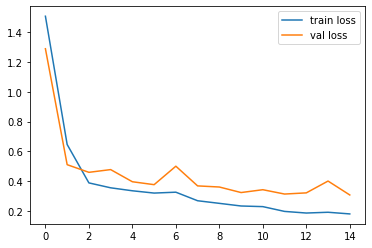

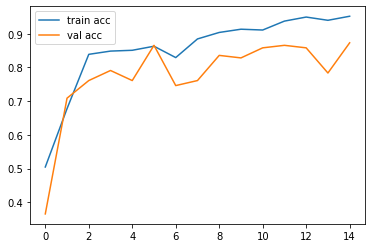

<Figure size 432x288 with 0 Axes>

In [36]:
# plot the loss
plt.plot(history2.history['loss'], label='train loss')
plt.plot(history2.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(history2.history['accuracy'], label='train acc')
plt.plot(history2.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [38]:
import numpy as np
vgg_val_loss = history2.history['val_loss']
vgg_val_acc = history2.history['val_accuracy']

print(f' valiadation loss is {np.average(vgg_val_loss)}')
print(f'validation accuracy is {np.average(vgg_val_acc)}')

 valiadation loss is 0.4497931698958079
validation accuracy is 0.7776119430859884


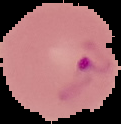

In [6]:
from tensorflow.keras.preprocessing import image
img = image.load_img('/content/drive/MyDrive/KAGGLE DATASETS/Malaria detection/dataset/Train/Parasite/C133P94ThinF_IMG_20151004_155721_cell_111.png')
img

##Making CNN Model from scratch

In [10]:
import tensorflow as tf
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPool2D,Flatten
from keras.layers import BatchNormalization,Dropout
from tensorflow.keras import initializers

initializer = tf.keras.initializers.HeNormal()

model_2 = Sequential()
model_2.add(Conv2D( 16, (3,3), activation='relu', kernel_initializer=initializer, input_shape=(224,224,3) ))
model_2.add(MaxPool2D((2,2)))

model_2.add(Conv2D( 32, (3,3), activation='relu' ))
model_2.add(MaxPool2D((2,2)))

model_2.add(Conv2D( 64, (3,3), activation='relu' ))
model_2.add(MaxPool2D((2,2)))

model_2.add(Flatten())

model_2.add(Dense(512, activation='relu'))
model_2.add(Dropout(0.2))

model_2.add(Dense(256, activation='relu'))
model_2.add(Dropout(0.4))

model_2.add(Dense(2, activation='softmax'))




In [12]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 16)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 64)      

In [13]:
model_2.compile(optimizer = 'adam', loss='categorical_crossentropy',metrics=['accuracy'] )

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255,      #Rescale 1./255 is to transform every pixel value from range [0,255] -> [0,1]
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
test_datagen = ImageDataGenerator(rescale = 1./255)


In [15]:

training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/KAGGLE DATASETS/Malaria detection/dataset/Train',
                                                 target_size=(224,224),
                                                 batch_size=32,
                                                 class_mode = 'categorical')
test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/KAGGLE DATASETS/Malaria detection/dataset/Test',
                                            target_size=(224,224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 416 images belonging to 2 classes.
Found 134 images belonging to 2 classes.


In [16]:
history = model_2.fit(training_set,
                      validation_data= test_set,
                      epochs=15,
                      steps_per_epoch = len(training_set),
                       validation_steps = len(test_set))

Epoch 1/15
13/13 [==============================] - 142s 10s/step - loss: 1.9345 - accuracy: 0.4976 - val_loss: 0.6926 - val_accuracy: 0.5522
Epoch 2/15
13/13 [==============================] - 6s 431ms/step - loss: 0.6922 - accuracy: 0.5096 - val_loss: 0.7007 - val_accuracy: 0.3507
Epoch 3/15
13/13 [==============================] - 6s 430ms/step - loss: 0.6917 - accuracy: 0.5096 - val_loss: 0.6943 - val_accuracy: 0.4478
Epoch 4/15
13/13 [==============================] - 6s 429ms/step - loss: 0.6926 - accuracy: 0.5457 - val_loss: 0.7158 - val_accuracy: 0.4030
Epoch 5/15
13/13 [==============================] - 6s 428ms/step - loss: 0.6938 - accuracy: 0.5096 - val_loss: 0.6812 - val_accuracy: 0.6194
Epoch 6/15
13/13 [==============================] - 6s 428ms/step - loss: 0.6864 - accuracy: 0.5553 - val_loss: 0.6946 - val_accuracy: 0.4925
Epoch 7/15
13/13 [==============================] - 6s 427ms/step - loss: 0.6764 - accuracy: 0.5745 - val_loss: 0.7251 - val_accuracy: 0.4403
Epoch 

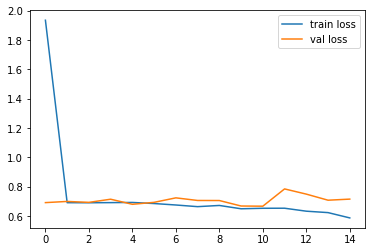

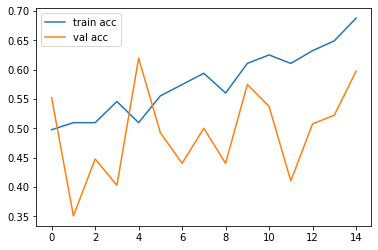

<Figure size 432x288 with 0 Axes>

In [17]:
# plot the loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

## Comparing Accuracy and loss of both models

In [20]:
import numpy as np
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

print(f' valiadation loss is {np.average(val_loss)}')
print(f'validation accuracy is {np.average(val_acc)}')

 valiadation loss is 0.7078853329022725
validation accuracy is 0.4930348257223765


In [40]:
import pandas as pd
table = pd.DataFrame(columns=['Model','Val loss', 'Val Acc'])

In [42]:
table = table.append(pd.DataFrame([['VGG 19',0.449,0.777]], columns=['Model','Val loss', 'Val Acc']))
table = table.append(pd.DataFrame([['Scratch',0.707,0.493]], columns=['Model','Val loss', 'Val Acc']))

<function matplotlib.pyplot.show>

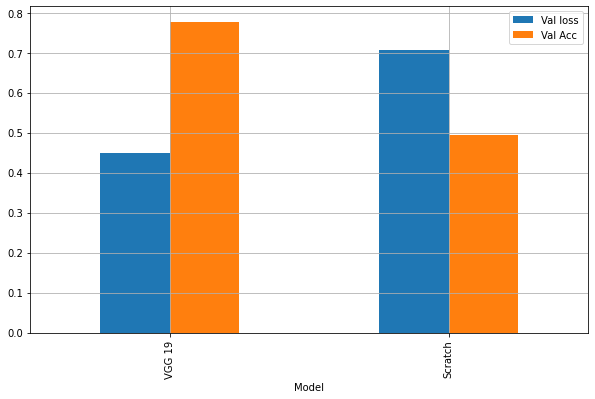

In [44]:
import matplotlib.pyplot as plt
table.plot(x='Model', kind='bar', figsize=(10,6), grid = True, fontsize=10)
# tab2.plot(x = "Model", kind = "bar", figsize = (10, 6), grid = True, fontsize = 10)
plt.show